# Neural & Behavioral Modeling - Week 14 (Exercises)
by 楊士寬 (r06521535@ntu.edu.tw)

In [ ]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [6]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [7]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
No GPU


## 1 Activation/Signal Function in RNN (10 points)

tanh(x) is a more popular choice of activation function than sigmoid(x) & relu(x) in contemporary RNNs.
Below please use simple RNN to compare 3 activation functions in terms of their learning efficiency and capacity. If there is any significant difference, please discuss why. 

nn.RNN(..., nonlinearity='relu') allows you to switch tanh to relu. However, you need some deep hacking of the source code to replace nn.Tanh with nn.Sigmoid. Alternatively, you can <a href="https://www.cpuheater.com/deep-learning/introduction-to-recurrent-neural-networks-in-pytorch/">code a simple RNN from scratch</a> to have a better control of everything!

### 1.0 Data: sin(t) → cos(t)

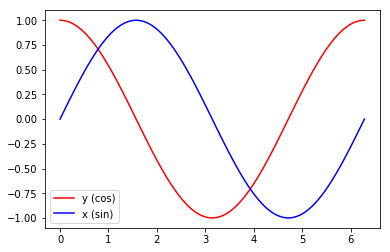

In [60]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)
plot(steps, y_np, 'r-', label='y (cos)')
plot(steps, x_np, 'b-', label='x (sin)')
plt.legend(loc='best');

### 1.1 RNN model for 1D-to-1D time-series regression (7 points)

我參考這個網頁的CODE : https://morvanzhou.github.io/tutorials/machine-learning/torch/4-03-RNN-regression/

### RNN_TANH

In [125]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step / image height
INPUT_SIZE = 1      # rnn input size / image width
LR = 0.02           # learning rate
DOWNLOAD_MNIST = False  # set to True if haven't download the data

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(  # 这回一个普通的 RNN 就能胜任
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
            nonlinearity='tanh'
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入

        outs = []    # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state


rnn = RNN()

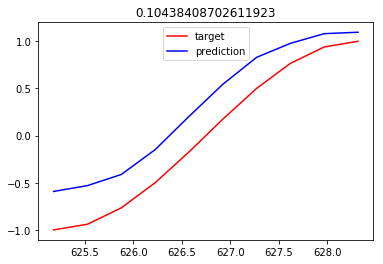

In [126]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state
#prediction_tanh=[]
loss_tanh = []
for step in range(200):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sine to predict cosine
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    h_state = h_state.data                  # get rid of the autograd part and retain the data part only
 
    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients
    #if step < 50:
    loss_tanh.append(loss.item()); 
# plotting
clf() # clear previous figure

plot(steps, y_np.flatten(), 'r-', label='target')
plot(steps, prediction.data.numpy().flatten(), 'b-', label='prediction')
#prediction_tanh.append(prediction.data.numpy())

title(loss.item()); legend(loc=9)
display(gcf()); clear_output(wait=True) # to allow dynamic plots

    

### RNN_RELU

In [127]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step / image height
INPUT_SIZE = 1      # rnn input size / image width
LR = 0.02           # learning rate
DOWNLOAD_MNIST = False  # set to True if haven't download the data

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(  # 这回一个普通的 RNN 就能胜任
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
            nonlinearity='relu'
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):  # 因为 hidden state 是连续的, 所以我们要一直传递这一个 state
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, output_size)
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作为 RNN 的一个输入

        outs = []    # 保存所有时间点的预测值
        for time_step in range(r_out.size(1)):    # 对每一个时间点计算 output
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state


rnn = RNN()

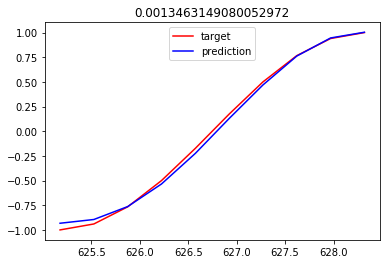

In [128]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = None      # for initial hidden state
step_line = []
#target = []
#prediction_relu = []
loss_relu = []
for step in range(200):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sine to predict cosine
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    h_state = h_state.data                  # get rid of the autograd part and retain the data part only
 
    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients
    
    step_line.append(step*np.pi)
    loss_relu.append(loss.item())
# plotting
clf() # clear previous figure
plot(steps, y_np.flatten(), 'r-', label='target')
#if step < 50:

#target.append(y_np.flatten())
plot(steps, prediction.data.numpy().flatten(), 'b-', label='prediction')
#prediction_relu.append(prediction.data.numpy().flatten())
title(loss.item()); legend(loc=9)
display(gcf()); clear_output(wait=True) # to allow dynamic plots
    

### 1.2 Conclusions (3 points)

Please write your discussion here.

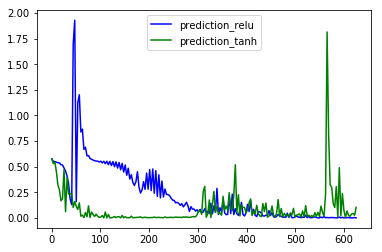

In [129]:
#clf() # clear previous figure
#plot(step_line,y_np.flatten(), 'r-', label='target')
plot(step_line,loss_relu, 'b-', label='prediction_relu')
plot(step_line,loss_tanh, 'g-', label='prediction_tanh')
legend(loc=9);

如果依照老師原本的設定step為100，從兩個的loss可以發現，prediction_tanh的loss比prediction_relu更早開始接近零，代表RNN_tanh的學習的精準度比較好，只是我把step加到200發現，後半段不知道是什麼原因讓RNN_tanh開始震盪，而RNN_relu的loss依舊繼續往零收過去，小結為RNN_tanh可以學得快且準確率高，但需要注意train的大小，而RNN_relu雖然比較慢，但可不用太擔心過度訓練的後果。